In [1]:
import numpy as np
import pandas as pd
from numpy.matlib import repmat
import matplotlib.pyplot as plt
# from scipy.stats import multivariate_normal
from numpy.linalg import norm
from matplotlib import pyplot
import pylab
from mpl_toolkits.mplot3d import Axes3D

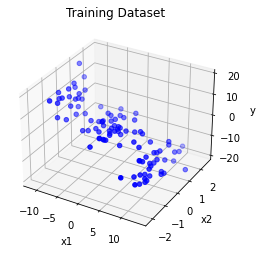

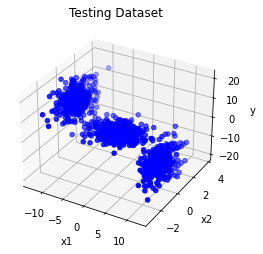

In [19]:
def hw2q2():
    Ntrain = 100
    data,labels100 = generateData(Ntrain)
    plot3(data[0,:],data[1,:],data[2,:], t='Training')
    xTrain = data[0:2,:]
    yTrain = data[2,:]

    
    Ntrain = 1000
    data,labels1k = generateData(Ntrain)
    plot3(data[0,:],data[1,:],data[2,:], t='Testing')
    xValidate = data[0:2,:]
    yValidate = data[2,:]
    
    return xTrain,yTrain,xValidate,yValidate,labels100,labels1k

def generateData(N):
    gmmParameters = {}
    gmmParameters['priors'] = [.3,.4,.3] # priors should be a row vector
    gmmParameters['meanVectors'] = np.array([[-10, 0, 10], [0, 0, 0], [10, 0, -10]])
    gmmParameters['covMatrices'] = np.zeros((3, 3, 3))
    gmmParameters['covMatrices'][:,:,0] = np.array([[1, 0, -3], [0, 1, 0], [-3, 0, 15]])
    gmmParameters['covMatrices'][:,:,1] = np.array([[8, 0, 0], [0, .5, 0], [0, 0, .5]])
    gmmParameters['covMatrices'][:,:,2] = np.array([[1, 0, -3], [0, 1, 0], [-3, 0, 15]])
    x,labels = generateDataFromGMM(N,gmmParameters)
    return x,labels

def generateDataFromGMM(N,gmmParameters):
#    Generates N vector samples from the specified mixture of Gaussians
#    Returns samples and their component labels
#    Data dimensionality is determined by the size of mu/Sigma parameters
    priors = gmmParameters['priors'] # priors should be a row vector
    meanVectors = gmmParameters['meanVectors']
    covMatrices = gmmParameters['covMatrices']
    n = meanVectors.shape[0] # Data dimensionality
    C = len(priors) # Number of components
    x = np.zeros((n,N))
    labels = np.zeros((1,N))
    # Decide randomly which samples will come from each component
    u = np.random.random((1,N))
    thresholds = np.zeros((1,C+1))
    thresholds[:,0:C] = np.cumsum(priors)
    thresholds[:,C] = 1
    for l in range(C):
        indl = np.where(u <= float(thresholds[:,l]))
        Nl = len(indl[1])
        labels[indl] = (l+1)
        u[indl] = 1.1 #marked as visited
        x[:,indl[1]] = np.transpose(np.random.multivariate_normal(meanVectors[:,l], covMatrices[:,:,l], Nl))
    return x,labels

def plot3(a,b,c,t, mark="o",col="b"):
 
    fig = plt.figure()
    ax= fig.add_subplot(111,projection='3d')
    ax.scatter(a, b, c,marker=mark,color=col)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("y")
    if t == 'Training':
        ax.set_title('Training Dataset')
    else:
        ax.set_title('Testing Dataset')

x1=np.zeros((2,100))
x2=np.zeros((2,1000))

y1=np.zeros((1,100))
y2=np.zeros((1,1000))

x1,y1,x2,y2,l1,l2 =hw2q2()

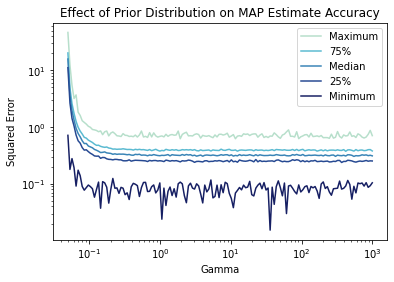

In [17]:
# 1.5(x - 0.6)(x - 0.2)(x + 0.8) = 1.5x^3 + 0.15x^2 - 0.9x + 0.162
W_TRUE = np.array([1.5, 0.15, -0.9, 0.162])

SIGMA = 0.35

I = np.identity(4)

N = 10

EXPERIMENTS = 500

# Returns the function ax^3 + bx^3 + cx + d, where w holds the
# values of [a, b, c, d].
def corrupted_cubic(x, w):
    [a, b, c, d] = w
    y = a*x**3 + b*x**2 + c*x + d
    v = np.random.normal(0, SIGMA, x.shape[1])
    return y + v

# Calculates the MAP estimate for the provided x and y samples
# using a given gamma term
def MAP_estimate(x, y, gamma):
    dependent_variables = np.array([
        np.sum(x**3 * y),
        np.sum(x**2 * y),
        np.sum(x * y),
        np.sum(y)
    ])
    s2_g2 = SIGMA**2 / gamma**2
    coefficient_matrix = np.array([
        [s2_g2 + np.sum(x**6), np.sum(x**5), np.sum(x**4), np.sum(x**3)],
        [np.sum(x**5), s2_g2 + np.sum(x**4), np.sum(x**3), np.sum(x**2)],
        [np.sum(x**4), np.sum(x**3), s2_g2 + np.sum(x**2), np.sum(x)   ],
        [np.sum(x**3), np.sum(x**2), np.sum(x), s2_g2 + N              ],
    ])
    return np.linalg.solve(coefficient_matrix, dependent_variables)

gamma_values = np.geomspace(0.05, 1000, 150)
error_rates = []
for gamma in gamma_values:
    this_error_rate = []
    for _ in range(EXPERIMENTS):
        y = corrupted_cubic(x1, W_TRUE)

        w_map = MAP_estimate(x1, y, gamma)
        square_l2_distance = np.sum((W_TRUE - w_map)**2)
        this_error_rate.append(square_l2_distance)
    this_error_rate.sort()
    error_rates.append(this_error_rate)

error_curve_min = [min(gamma_error_rate) for gamma_error_rate in error_rates]
error_curve_25p = [np.percentile(gamma_error_rate, 25) for gamma_error_rate in error_rates]
error_curve_med = [np.median(gamma_error_rate) for gamma_error_rate in error_rates]
error_curve_75p = [np.percentile(gamma_error_rate, 75) for gamma_error_rate in error_rates]
error_curve_max = [max(gamma_error_rate) for gamma_error_rate in error_rates]

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

plt.title("Effect of Prior Distribution on MAP Estimate Accuracy")
plt.xlabel("Gamma")
plt.ylabel("Squared Error")

plt.plot(
    gamma_values, error_curve_max, '#b7dfcb',
    gamma_values, error_curve_75p, '#5abad1',
    gamma_values, error_curve_med, '#3984b6',
    gamma_values, error_curve_25p, '#264992',
    gamma_values, error_curve_min, '#161f63',
)

plt.legend([
    'Maximum',
    '75%',
    'Median',
    '25%',
    'Minimum',
])

plt.show()
